# Amazon Bin Images classification using Convolutional Neural Network on AWS SageMaker
**This notebook walks through implementation of Image Classification Machine Learning Model to classify the number of objects in each bin (5 classes) using the Amazon Bin Image Dataset (https://registry.opendata.aws/amazon-bin-imagery/)**

- We will be using a pre-trained ResNet-50 model from pytorch vision library (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50)
- We will be adding in one Fully connected Neural network Layer on top of the above ResNet-50 model.
- Note: We will be using concepts of Transfer learning and so we will be freezing all the existing Convolutional layers in the pre-trained ResNet-50 model and only changing gradients for the one fully connected layer that we have added.
- Then we will perform Hyperparameter tuning, to help figure out the best hyperparameter to be used for our model.
- Next we will be using the best hyperparameter and fine-tuning our ResNet-50 model.
- We will also be adding in configuration for Profiling and Debugging our training mode by adding in relevant hooks in the Training and Testing (Evaluation) phases.
- Next we will be deploying our model. While deploying, we will create our custom inference script. The custom inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
- Finally we will be testing out our model with some test images of bins, to verify if the model is working as per our expectations.

In [2]:
# Install any packages that might need
!pip install smdebug
import sagemaker
import boto3
import os
import io
import json
import IPython
import shutil
import pandas as pd
import numpy as np
import base64
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from mpl_toolkits.axes_grid1 import host_subplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 4.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.7 MB/s eta 0:00:00:00:01
[2023-03-22 07:09:18.943 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
# Initialize some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-644490318351


## Data Preparation

Read the 'file_list.json' file which is contained a list of more than 10,000 image path in AWS. Create a dataframe which is contained information of image ids and labels.

In [4]:
with open('file_list.json', 'r') as f:
    d=json.load(f)
    
label = []
file1 = []
for k, v in d.items():
    label.append(k)
    for file_path in tqdm(v):
        file_name = os.path.basename(file_path).split('.')[0]
        file1.append((file_name, k))

100%|██████████| 1875/1875 [00:00<00:00, 456829.51it/s]


In [5]:
df = pd.DataFrame(file1, columns =['Img_id', 'Label'])

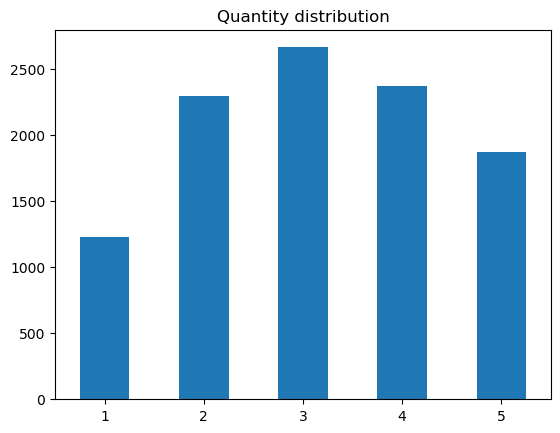

In [22]:
df['Label'].value_counts().reindex(["1", "2", "3", "4", "5"]).plot(kind='bar', rot=0)
plt.title('Quantity distribution')
plt.show()

## Dataset

Split the dataset into 72% training, 18% validation and 10% testing.

In [6]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(df['Img_id'], df['Label'], test_size=0.1, random_state=42)

In [7]:
X_train_2, X_val_1, Y_train_2, Y_val_1 = train_test_split(X_train_1, Y_train_1, test_size=0.2, random_state=42)

In [8]:
X_train_l = pd.Series.tolist(X_train_2)
Y_train_l = pd.Series.tolist(Y_train_2)
train_list = []
for i in range(len(X_train_2)):
    train_list.append((X_train_l[i], Y_train_l[i]))

In [9]:
X_test_l = pd.Series.tolist(X_test_1)
Y_test_l = pd.Series.tolist(Y_test_1)
test_list = []
for i in range(len(X_test_1)):
    test_list.append((X_test_l[i], Y_test_l[i]))

In [10]:
X_val_l = pd.Series.tolist(X_val_1)
Y_val_l = pd.Series.tolist(Y_val_1)
val_list = []
for i in range(len(X_val_1)):
    val_list.append((X_val_l[i], Y_val_l[i]))

Download image data, rename from 'name.jpg' to 'label_name.jpg' and save images in label folders (in test/train/valid folders) respectively.

In [11]:
s3_client = boto3.client('s3')
for k, v in train_list:
    directory = os.path.join('ABID/train', v)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_name_1= k + '.jpg'
    file_name_2= v + '_' + k + '.jpg'
    s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name_1), os.path.join(directory, file_name_2))

In [12]:
for k, v in test_list:
    directory = os.path.join('ABID/test', v)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_name_1= k + '.jpg'
    file_name_2= v + '_' + k + '.jpg'
    s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name_1), os.path.join(directory, file_name_2))

In [13]:
for k, v in val_list:
    directory = os.path.join('ABID/valid', v)
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_name_1= k + '.jpg'
    file_name_2= v + '_' + k + '.jpg'
    s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name_1), os.path.join(directory, file_name_2))

Upload the data to AWS S3

In [14]:
prefix ="ABID"
print("Starting to upload ABID")

inputs = sagemaker_session.upload_data(path="ABID", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

Starting to upload ABID
Input path ( S3 file path ): s3://sagemaker-us-east-1-644490318351/ABID


In [15]:
inputs = 's3://sagemaker-us-east-1-644490318351/ABID'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-644490318351/ABID


## Hyperparameter Tunning

In [16]:
# Import all the required modules for tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a difference (more correct or better) way to calculate the weight decay related computations
# So we will be using weight_decay and eps hyperparameter tuning as well, along with the learning rate and batch size params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1)
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [19]:
# Create estimators for HPs
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "ABID-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.2xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=3,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [20]:
# Fit the HP Tuner
tuner.fit({"training": inputs }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [23]:
# Describe the tuning results
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230322-0742')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,eps,lr,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,5.705650e-09,0.008916,0.011024,pytorch-training-230322-0742-005-65d7a427,Stopped,1.5784,2023-03-22 08:10:44+00:00,2023-03-22 08:24:14+00:00,810.0
3,9.343963e-09,0.003248,0.018649,pytorch-training-230322-0742-003-24d5075b,Stopped,1.5575,2023-03-22 07:43:41+00:00,2023-03-22 07:57:16+00:00,815.0
2,7.064919e-09,0.000323,0.001377,pytorch-training-230322-0742-004-8b9fa3a6,Stopped,1.5522,2023-03-22 07:57:26+00:00,2023-03-22 08:10:06+00:00,760.0
4,9.293731e-09,0.001684,0.097399,pytorch-training-230322-0742-002-6d8a73b2,Stopped,1.5291,2023-03-22 07:43:37+00:00,2023-03-22 08:09:35+00:00,1558.0
5,1.266321e-09,0.002922,0.015234,pytorch-training-230322-0742-001-bfd854a2,Completed,1.4948,2023-03-22 07:43:36+00:00,2023-03-22 08:33:00+00:00,2964.0
0,9.684844e-09,0.001860,0.097048,pytorch-training-230322-0742-006-616a9b4a,Completed,1.4525,2023-03-22 08:10:21+00:00,2023-03-22 08:59:04+00:00,2923.0


In [24]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameter of the best trained model
best_estimator.hyperparameters()


2023-03-22 08:59:06 Starting - Found matching resource for reuse
2023-03-22 08:59:06 Downloading - Downloading input data
2023-03-22 08:59:06 Training - Training image download completed. Training in progress.
2023-03-22 08:59:06 Uploading - Uploading generated training model
2023-03-22 08:59:06 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'eps': '9.684844460725908e-09',
 'lr': '0.0018595945720688372',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"ABID-classification-hpo-2023-03-22-07-42-29-285"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-644490318351/ABID-classification-hpo-2023-03-22-07-42-29-285/source/sourcedir.tar.gz"',
 'weight_decay': '0.09704827256733949'}

In [25]:
best_hyperparameters={'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparameters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparameters post Hyperparameter fine tuning are : 
 {'eps': '9.684844460725908e-09', 'lr': '0.0018595945720688372', 'weight_decay': '0.09704827256733949'}


## Model Profiling, Debugging and Training

In [26]:
# Set up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [27]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs }, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-22-09-12-21-839


2023-03-22 09:12:24 Starting - Starting the training job...
2023-03-22 09:12:51 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-22 09:13:52 Downloading - Downloading input data...
2023-03-22 09:14:32 Training - Downloading the training image......
2023-03-22 09:15:32 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-22 09:15:31,388 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-22 09:15:31,417 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-22 09:15:31,420 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-22 09:15:31,695 sagemaker-training-toolkit INFO     Invoking u

In [28]:
# Fetch job name, client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [29]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2023-03-22-09-12-21-839
Client: <botocore.client.SageMaker object at 0x7fdf94782350>
Description: {'TrainingJobName': 'pytorch-training-2023-03-22-09-12-21-839', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:644490318351:training-job/pytorch-training-2023-03-22-09-12-21-839', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'eps': '"9.684844460725908e-09"', 'lr': '"0.0018595945720688372"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-03-22-09-12-21-839"', 'sagemaker_program': '"train.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/source/sourcedir.tar.gz"', 'weight_decay': '"0.09704827256733949"'}, 'AlgorithmSpecification': {'TrainingImage': 

In [30]:
# Create a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-22 09:47:51.515 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/debug-output
[2023-03-22 09:47:51.951 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [31]:
trial.tensor_names() #all the tensor names

[2023-03-22 09:47:58.845 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-22 09:47:59.868 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [32]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

118

In [33]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

180

In [34]:
# Define a utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

# Define a plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


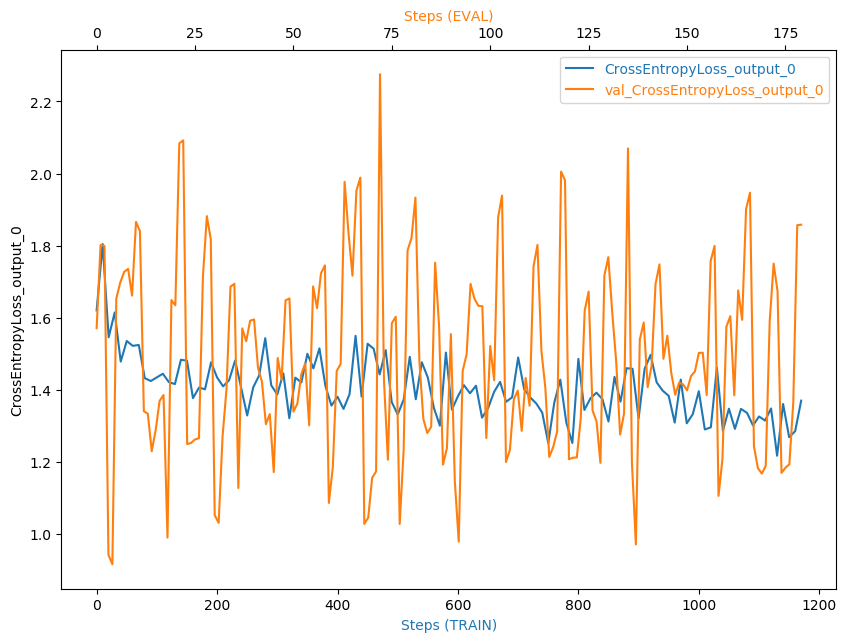

In [35]:
# Plot the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [44]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/rule-output


In [45]:
! aws s3 ls {rule_output_path} --recursive

2023-03-22 09:44:56     418798 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-22 09:44:55     274593 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-22 09:44:50        192 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-22 09:44:50      65256 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-22 09:44:50        126 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-22 09:44:50        331 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-22 09:44:50       4515 pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-re

In [46]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-12-21-839/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-ea

In [52]:
# Get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [48]:
# Zip the ProfilerReport in order to export and upload it later for submission
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/nd009t-capstone-starter/starter/profiler_report.zip'

## Model Deploying and Querying

In [36]:
# Deploy the model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-22-09-50-42-882
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-22-09-50-42-882
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-22-09-50-42-882


----!

In [38]:
# Run an prediction on the endpoint

# Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-644490318351/pytorch-training-2023-03-22-09-50-42-882/model.tar.gz"

# We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

# If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-22-09-59-19-573
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-22-09-59-20-391
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-22-09-59-20-391


---------!

Test image no: 1
Below is the image that we will be testing:


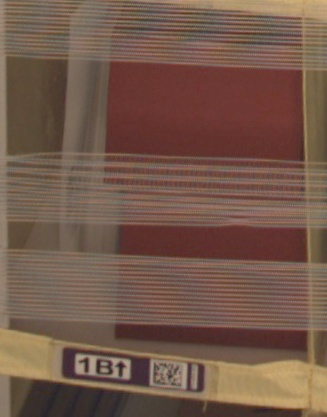

Expected quantity: 3
Response: [[-1.191691517829895, 0.38471338152885437, 0.7191458344459534, 0.5854431390762329, -0.5240654945373535]]
Response/Inference for the above image is: [3]
----------------------------------------------------------------------
Test image no: 2
Below is the image that we will be testing:


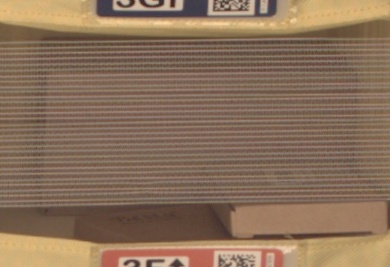

Expected quantity: 3
Response: [[-0.2933600842952728, 0.11254195868968964, 0.17918112874031067, 0.06353281438350677, 0.05942096561193466]]
Response/Inference for the above image is: [3]
----------------------------------------------------------------------
Test image no: 3
Below is the image that we will be testing:


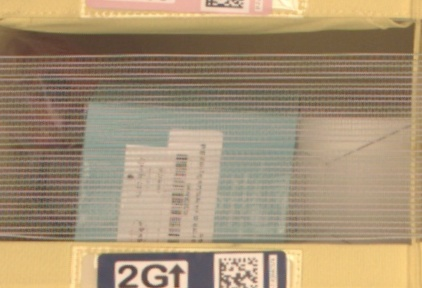

Expected quantity: 3
Response: [[-1.9472163915634155, 0.6626558899879456, 0.7473654747009277, 0.21367032825946808, 0.3016740381717682]]
Response/Inference for the above image is: [3]
----------------------------------------------------------------------


In [53]:
# Test the deployed endpoint using some test images
# Solution 1: Using the Predictor object directly.

test_dir = "./ABID/test/3/"
test_images = ["3_00031.jpg", "3_08813.jpg", "3_104478.jpg"]
test_images_expected_output = [3, 3, 3]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected quantity: {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is: {predicted_dog_breed}")
        print("----------------------------------------------------------------------")

In [40]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2023-03-22-09-59-20-391


Test image no: 1
Below is the image that we will be testing:


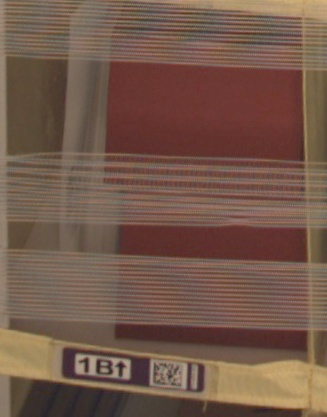

Expected quantity: 3
Response: [[-1.19169152  0.38471338  0.71914583  0.58544314 -0.52406549]]
Response/Inference for the above image is: [3]
Test image no: 2
Below is the image that we will be testing:


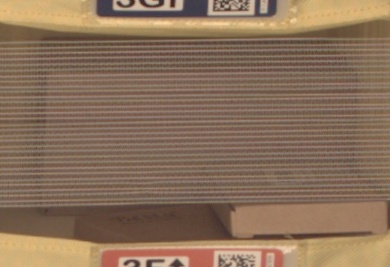

Expected quantity: 3
Response: [[-0.29336008  0.11254196  0.17918113  0.06353281  0.05942097]]
Response/Inference for the above image is: [3]
Test image no: 3
Below is the image that we will be testing:


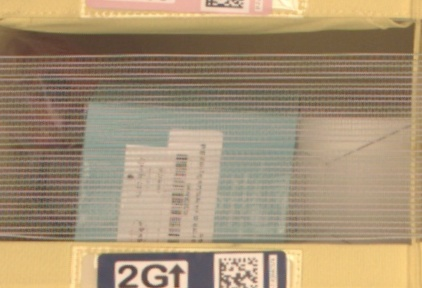

Expected quantity: 3
Response: [[-1.94721639  0.66265589  0.74736547  0.21367033  0.30167404]]
Response/Inference for the above image is: [3]


In [54]:
# Solution 2: Using boto3
# Use the runtime boto3 client to test the deployed models endpoint

# Set up the  environment variables
ENDPOINT_NAME = endpoint_name

# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./ABID/test/3/"
test_images = ["3_00031.jpg", "3_08813.jpg", "3_104478.jpg"]
test_images_expected_output = [3, 3, 3]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected quantity: {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is: {predicted_dog_breed}")

In [ ]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()